In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [4]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'Train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [5]:
data_dir = r'C:\Users\ND01VY\OneDrive - Aalborg Universitet\Desktop\thermal images UL - Split-Train-Tes'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes

print(class_names)

['BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [6]:
inputs, classes = next(iter(dataloaders['Train']))

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    loss_plt = []  
    accuracy_plt = []
    test_loss_plt = []  
    test_accuracy_plt = []
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, classes in dataloaders[phase]:
                inputs = inputs.to(device)
                classes = classes.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, classes)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == classes.data)

            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
             
            if phase == 'Train':
                accuracy_plt.append(epoch_acc)
                loss_plt.append(epoch_loss)
                
            if phase == 'Test':
                test_accuracy_plt.append(epoch_acc)
                test_loss_plt.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))
    
    plt.plot(accuracy_plt,label='Training Accuracy')  
    plt.plot(test_accuracy_plt,label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, 19))
    plt.title('Training vs Test Accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(loss_plt,label='Training Loss')  
    plt.plot(test_loss_plt,label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, 19))
    plt.title('Training vs Test Loss')
    plt.legend()
    plt.show()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/19
----------
Train Loss: 1.4190 Acc: 0.4665
Test Loss: 0.9683 Acc: 0.6484

Epoch 1/19
----------
Train Loss: 0.8656 Acc: 0.6732
Test Loss: 0.8433 Acc: 0.7344

Epoch 2/19
----------
Train Loss: 0.7471 Acc: 0.7283
Test Loss: 0.6774 Acc: 0.7578

Epoch 3/19
----------
Train Loss: 0.6797 Acc: 0.7480
Test Loss: 0.6521 Acc: 0.7891

Epoch 4/19
----------
Train Loss: 0.5707 Acc: 0.8307
Test Loss: 0.6352 Acc: 0.7891

Epoch 5/19
----------
Train Loss: 0.5417 Acc: 0.8130
Test Loss: 0.6775 Acc: 0.7734

Epoch 6/19
----------
Train Loss: 0.5369 Acc: 0.8130
Test Loss: 0.5588 Acc: 0.8125

Epoch 7/19
----------
Train Loss: 0.4558 Acc: 0.8583
Test Loss: 0.5317 Acc: 0.8359

Epoch 8/19
----------
Train Loss: 0.4439 Acc: 0.8583
Test Loss: 0.5328 Acc: 0.8203

Epoch 9/19
----------
Train Loss: 0.4546 Acc: 0.8504
Test Loss: 0.5396 Acc: 0.7969

Epoch 10/19
----------
Train Loss: 0.4521 Acc: 0.8504
Test Loss: 0.5396 Acc: 0.8047

Epoch 11/19
----------
Train Loss: 0.4438 Acc: 0.8583
Test Loss: 0.5387 Acc

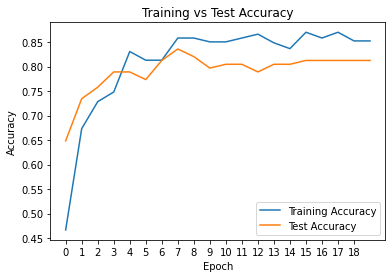

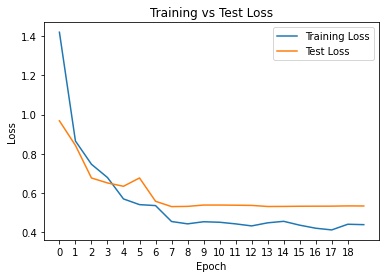

In [8]:
model = models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 6)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)



In [9]:
inputs, labels = next(iter(dataloaders['Test']))

<AxesSubplot:>

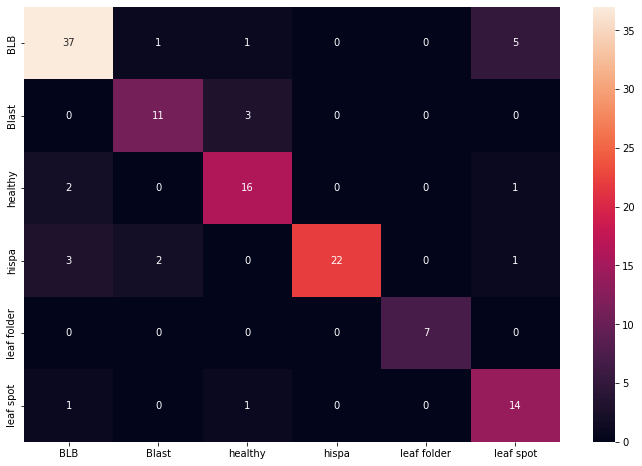

In [10]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['Test']:
        output = model(inputs) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


classes = ('BLB', 'Blast', 'healthy', 'hispa', 'leaf folder', 'leaf spot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_true, target_names=classes))

              precision    recall  f1-score   support

         BLB       0.84      0.86      0.85        43
       Blast       0.79      0.79      0.79        14
     healthy       0.84      0.76      0.80        21
       hispa       0.79      1.00      0.88        22
 leaf folder       1.00      1.00      1.00         7
   leaf spot       0.88      0.67      0.76        21

    accuracy                           0.84       128
   macro avg       0.85      0.85      0.85       128
weighted avg       0.84      0.84      0.83       128



In [12]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2,3,4,5]:
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_true)==l, np.array(y_pred)==l, pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

,class,sensitivity,specificity
0,0,0.928571,0.840909
1,1,0.973684,0.785714
2,2,0.954128,0.842105
3,3,1.000000,0.785714
4,4,1.000000,1.000000
5,5,0.937500,0.875000
